# Análise Exploratória de Dados

Análise do mercado de aluguéis temporários na cidade de Nova York (EUA).

Dados disponibilizados pela Indicium para a realização do desafio Lighthouse.

Autor: Raphael Fleury

## Objetivo
O objetivo desta análise é identificar quais fatores mais interferem no preço dos anúncios e, a partir disso, responder às seguintes perguntas:
- Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
- O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
- Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Além disso, esses dados também serão usados para desenvolver um modelo de previsão de preços.

## Estratégia
Para obter um resultado preciso sobre como o preço se altera conforme as características do apartamento, serão adotados os seguintes passos:
- Limpeza dos dados, removendo outliers que podem distorcer as estatísticas
- Inserção de informações a partir de outra base de dados para obter mais fatores que podem influenciar no preço
- Transformação de variáveis qualitativas em quantitativas para calcular sua correlação com o preço

## 1. Análise e limpeza dos dados

### 1.1. Análise inicial, ajustes de tipo e tratamento de nulos

Leitura do CSV:

In [605]:
import pandas as pd
apartamentos = pd.read_csv('./datasets/precificacao.csv')

Visualização dos dados:

In [606]:
apartamentos.head(2)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


Analisando o tipo de cada coluna e o número de valores não-nulos:

In [607]:
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

Convertendo a coluna "ultima_review" para o formato adequado, de texto para data:

In [608]:
apartamentos["ultima_review"] = pd.to_datetime(apartamentos["ultima_review"])
apartamentos["ultima_review"].describe()

count                            38842
mean     2018-10-04 01:46:50.710055936
min                2011-03-28 00:00:00
25%                2018-07-08 00:00:00
50%                2019-05-19 00:00:00
75%                2019-06-23 00:00:00
max                2019-07-08 00:00:00
Name: ultima_review, dtype: object

Verificando quantos valores nulos há em cada coluna:

In [609]:
nulos = apartamentos.isnull().sum()
nulos[nulos > 0]

nome                  16
host_name             21
ultima_review      10052
reviews_por_mes    10052
dtype: int64

Substituindo valores nulos:
- nome: substituídos por um texto vazio
- host_name: substituídos pelo id do host
- reviews_por_mes: substituídos por 0

In [610]:
apartamentos['nome'] = apartamentos['nome'].fillna('')
apartamentos['host_name'] = apartamentos['host_name'].fillna(apartamentos["host_id"].astype(str))
apartamentos['reviews_por_mes'] = apartamentos['reviews_por_mes'].fillna(0)
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48894 non-null  int64         
 1   nome                           48894 non-null  object        
 2   host_id                        48894 non-null  int64         
 3   host_name                      48894 non-null  object        
 4   bairro_group                   48894 non-null  object        
 5   bairro                         48894 non-null  object        
 6   latitude                       48894 non-null  float64       
 7   longitude                      48894 non-null  float64       
 8   room_type                      48894 non-null  object        
 9   price                          48894 non-null  int64         
 10  minimo_noites                  48894 non-null  int64         
 11  numero_de_revie

### 1.2. Busca de outliers

Analisando estatísticas sobre cada coluna a fim de encontrar dados destoantes e potencialmente prejudiciais às análises:

In [611]:
apartamentos.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842,48894.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,2018-10-04 01:46:50.710055936,1.090928,7.144005,112.776169
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.000000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,2018-07-08 00:00:00,0.040000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,2019-05-19 00:00:00,0.370000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2019-06-23 00:00:00,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,NaN,1.597294,32.952855,131.618692


A partir desta tabela é possível observar que:
- Há apartamentos com preço igual a 0
- Há apartamentos com preços que se destoam muito
- Há poucos apartamentos com um número mínimo de noites altíssimo
- Há apartamentos que não estão disponíveis em nenhum dia
- Há poucos hospedeiros com um número de listagens muito mais alto que o geral

#### 1.2.1. Buscando outliers no preço

Analisando os apartamentos com o preço igual a zero para tentar encontrar alguma justificativa:

In [612]:
apartamentos[apartamentos['price'] == 0].describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,1.100000e+01,1.100000e+01,11.000000,11.000000,11.0,11.000000,11.000000,10,11.000000,11.000000,11.000000
mean,2.057179e+07,5.862573e+07,40.712058,-73.925670,0.0,7.363636,34.272727,2018-12-30 00:00:00,1.579091,4.272727,120.909091
min,1.875060e+07,1.641537e+06,40.681730,-73.975970,0.0,1.000000,0.000000,2017-10-27 00:00:00,0.000000,1.000000,0.000000
25%,2.056598e+07,1.192073e+07,40.686510,-73.943585,0.0,1.500000,2.500000,2018-05-10 06:00:00,0.130000,3.000000,14.000000
50%,2.063963e+07,8.632710e+07,40.692110,-73.913420,0.0,2.000000,12.000000,2019-06-04 00:00:00,0.530000,5.000000,127.000000
75%,2.078688e+07,9.414883e+07,40.716500,-73.910490,0.0,4.500000,74.000000,2019-06-21 18:00:00,3.420000,6.000000,199.000000
max,2.130432e+07,1.316976e+08,40.832960,-73.886680,0.0,30.000000,95.000000,2019-06-24 00:00:00,4.370000,6.000000,333.000000
std,6.767257e+05,4.828458e+07,0.045317,0.025821,0.0,11.262972,41.523706,NaN,1.906628,2.053821,112.128011


Como não foi possível encontrar nenhum padrão muito diferente dos outros apartamentos, eles serão retirados da análise, já que podem interferir nos cálculos de como cada variável interfere no preço:

In [613]:
apartamentos = apartamentos[apartamentos['price'] > 0]
apartamentos['price'].describe()

count    48883.000000
mean       152.755130
std        240.172716
min         10.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Agora será feita a análise dos apartamentos cujo preço se destoa muito dos demais, a fim de descobrir se isso pode ser um erro ou se esses apartamentos realmente valem mais do que os outros.

Para isso, serão selecionados os apartamentos que se destoam a partir do cálculo do [intervalo interquartil](https://study-com.translate.goog/academy/lesson/interquartile-range-definition-formula-example.html?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=wa):

In [614]:
Q1 = apartamentos['price'].quantile(0.25)
Q3 = apartamentos['price'].quantile(0.75)
IQR = Q3 - Q1

minimo = Q1 - 1.5 * IQR
maximo = Q3 + 1.5 * IQR

f'''Os outliers estão abaixo de {minimo} e acima de {maximo}, sendo o IQR = {IQR}'''

'Os outliers estão abaixo de -90.0 e acima de 334.0, sendo o IQR = 106.0'

In [615]:
# Ignorando os outliers abaixo do mínimo pois não há apartamentos com preço negativo
outliers = apartamentos[apartamentos['price'] > maximo]
qtd_outliers = len(outliers)
qtd_apartamentos = len(apartamentos)

f'{qtd_outliers} apartamentos são outliers, representando {qtd_outliers/qtd_apartamentos:.2%} do total'

'2972 apartamentos são outliers, representando 6.08% do total'

Uma boa forma de saber se esses preços fazem sentido é compará-los com a média do bairro:

In [616]:
preco_medio_bairro = apartamentos.groupby('bairro')['price'].mean()

# Calcula a diferença e a proporção entre o preço do apartamento e o preço médio do bairro
outliers_bairro = outliers.merge(preco_medio_bairro, on="bairro", suffixes=("", "_media_bairro"))
outliers_bairro["diff_media_bairro"] = outliers_bairro["price"] - outliers_bairro["price_media_bairro"]
outliers_bairro["proporcao"] = outliers_bairro["price"] / outliers_bairro["price_media_bairro"]

# Seleciona apenas os que estão acima da média do bairro e ordena pela proporção
outliers_bairro = outliers_bairro[outliers_bairro['diff_media_bairro'] > 0]
outliers_bairro = outliers_bairro.sort_values(by="proporcao", ascending=False)

outliers_bairro[['nome', 'room_type', 'bairro', 'price', 'price_media_bairro', 'diff_media_bairro', 'proporcao']]

,nome,room_type,bairro,price,price_media_bairro,diff_media_bairro,proporcao
540,Furnished room in Astoria apartment,Private room,Astoria,10000,117.187778,9882.812222,85.333131
424,Spanish Harlem Apt,Entire home/apt,East Harlem,9999,133.198747,9865.801253,75.068274
2619,Gem of east Flatbush,Private room,East Flatbush,7500,104.222000,7395.778000,71.961774
949,Luxury 1 bedroom apt. -stunning Manhattan views,Entire home/apt,Greenpoint,10000,144.952424,9855.047576,68.988153
701,"Quiet, Clean, Lit @ LES & Chinatown",Private room,Lower East Side,9999,186.312843,9812.687157,53.667798
...,...,...,...,...,...,...,...
2922,"HUGE Tribeca/SOHO Loft - 2,200 Square Feet!!",Private room,Tribeca,500,490.638418,9.361582,1.019080
1508,"The ""TriBeCa Loft"" #5 | A brand New 2 beds Loft",Entire home/apt,Tribeca,499,490.638418,8.361582,1.017042
1507,"The ""TriBeCa LOFT"" #3 | A stylish 2 bed apt",Entire home/apt,Tribeca,499,490.638418,8.361582,1.017042
1422,Prime Tribeca Loft,Entire home/apt,Tribeca,499,490.638418,8.361582,1.017042


A partir dessa análise é possível identificar que há apartamentos até 80 vezes mais caros que a média do bairro, o que é um forte de indício de erro, ou então de imóveis extremamente luxuosos em relação ao resto do bairro.

Para evitar distorções estatísticas, serão removidos da análise os apartamentos em que o preço é mais de 4 vezes maior que a média do bairro:

In [617]:
grandes_outliers = outliers_bairro[outliers_bairro['proporcao'] > 4]
apartamentos = apartamentos[~apartamentos['id'].isin(grandes_outliers['id'])]
apartamentos['price'].describe()

count    48298.000000
mean       137.557187
std        107.387599
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       1500.000000
Name: price, dtype: float64

#### 1.2.2. Número mínimo de noites x Disponibilidade no ano

In [618]:
indisponiveis = apartamentos[apartamentos['disponibilidade_365'] == 0]
len(indisponiveis)

17407

In [619]:
disp_insuficiente = apartamentos[apartamentos['minimo_noites'] > apartamentos['disponibilidade_365']]
len(disp_insuficiente) - len(indisponiveis)

829

In [620]:
proporcao_indisponives = len(indisponiveis) / len(apartamentos)
proporcao_disp_insuficiente = (len(disp_insuficiente) - len(indisponiveis)) / len(apartamentos)

f'{proporcao_indisponives:.2%} dos apartamentos estão indisponíveis e mais \
{proporcao_disp_insuficiente:.2%} dos apartamentos tem um período mínimo de noites menor que a disponibilidade no ano'

'36.04% dos apartamentos estão indisponíveis e mais 1.72% dos apartamentos tem um período mínimo de noites menor que a disponibilidade no ano'

Apesar de haver tantos apartamentos indisponíveis, é natural que isso aconteça e por ser uma quantidade tão grande serão importantes para a análise de preço, logo não serão retirados.

## 2. Adicionando mais dados

### 2.1. Restaurantes próximos

Um fator que pode ser determinante no preço é a quantidade de restaurantes próximos ao local. Podemos ter uma estimativa adicionando [este dataset obtido no Kaggle](https://www.kaggle.com/datasets/beridzeg45/nyc-restaurants), que lista restaurantes em Nova York com dados coletados do Google Maps.

In [621]:
restaurantes = pd.read_csv('./datasets/restaurantes.csv')
restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   URL               670 non-null    object 
 1   Name              670 non-null    object 
 2   Rating            666 non-null    float64
 3   Rating Count      666 non-null    float64
 4   Detailed Ratings  670 non-null    object 
 5   Price Category    547 non-null    float64
 6   Address           670 non-null    object 
 7   Lat               670 non-null    float64
 8   Lon               670 non-null    float64
 9   ZipCode           670 non-null    int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 52.5+ KB


Calculando restaurantes próximos a cada apartamento:

In [623]:
from scipy.spatial import cKDTree

def contagem_restaurantes(apartamentos_df):
    coords_apartamentos = apartamentos_df[['latitude', 'longitude']].to_numpy()
    coords_restaurantes = restaurantes[['Lat', 'Lon']].to_numpy()
    tree_restaurantes = cKDTree(coords_restaurantes)

    raio = 0.0045 # (500 metros ~= 0.0045 graus)
    contagem_restaurantes = tree_restaurantes.query_ball_point(coords_apartamentos, r=raio)
    return [len(i) for i in contagem_restaurantes]

apartamentos["num_restaurantes_proximos"] = contagem_restaurantes(apartamentos)
apartamentos[['id', 'num_restaurantes_proximos']].head()

,id,num_restaurantes_proximos
0,2595,3
1,3647,1
2,3831,0
3,5022,0
4,5099,1


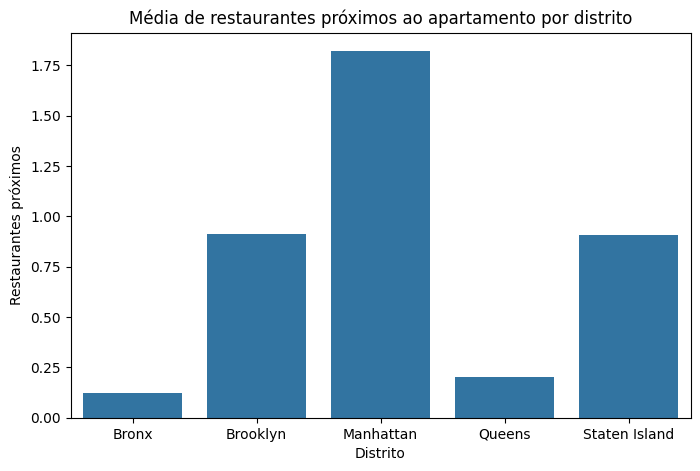

In [656]:
import matplotlib.pyplot as plt
import seaborn as sns

data = apartamentos.groupby("bairro_group")["num_restaurantes_proximos"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="bairro_group", y="num_restaurantes_proximos", data=data)
plt.title("Média de restaurantes próximos ao apartamento por distrito")
plt.xlabel("Distrito")
plt.ylabel("Restaurantes próximos")
plt.show()

## 3. Correlação de variáveis com o preço

### 3.1. Transformação

Temos no momento as seguintes colunas:

In [624]:
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48298 entries, 0 to 48893
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48298 non-null  int64         
 1   nome                           48298 non-null  object        
 2   host_id                        48298 non-null  int64         
 3   host_name                      48298 non-null  object        
 4   bairro_group                   48298 non-null  object        
 5   bairro                         48298 non-null  object        
 6   latitude                       48298 non-null  float64       
 7   longitude                      48298 non-null  float64       
 8   room_type                      48298 non-null  object        
 9   price                          48298 non-null  int64         
 10  minimo_noites                  48298 non-null  int64         
 11  numero_de_reviews   

Para calcular a correlação com os preços, serão transformadas as seguintes colunas:
- <b>bairro, bairro_group e room_type:</b> serão transformados em códigos numéricos
- <b>ultima_review:</b> será contabilizado o número decorrido de dias desde a última avaliação

In [625]:
apartamentos_num = apartamentos \
    .select_dtypes(include=['int64', 'float64']) \
    .drop(columns=['id', 'host_id'])

apartamentos_num['bairro'] = apartamentos['bairro'].astype('category').cat.codes
apartamentos_num['distrito'] = apartamentos['bairro_group'].astype('category').cat.codes
apartamentos_num['room_type'] = apartamentos['room_type'].astype('category').cat.codes
apartamentos_num['days_since_last_review'] = (pd.Timestamp.now() - apartamentos['ultima_review']).dt.days
apartamentos_num.head()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,num_restaurantes_proximos,bairro,distrito,room_type,days_since_last_review
0,40.75362,-73.98377,225,1,45,0.38,2,355,3,127,2,0,2086.0
1,40.80902,-73.94190,150,3,0,0.00,1,365,1,94,2,1,NaN
2,40.68514,-73.95976,89,1,270,4.64,1,194,0,41,1,0,2041.0
3,40.79851,-73.94399,80,10,9,0.10,1,0,0,61,2,0,2269.0
4,40.74767,-73.97500,200,3,74,0.59,1,129,1,137,2,0,2054.0


### 3.2. Cálculo da correlação

Como temos muitas variáveis categóricas, o método spearman se mostra eficiente para este cálculo.

In [626]:
apartamentos_num.corr(method="spearman")['price'].sort_values(ascending=False)

price                            1.000000
num_restaurantes_proximos        0.232155
bairro                           0.164319
latitude                         0.139831
distrito                         0.127269
minimo_noites                    0.106327
disponibilidade_365              0.077057
days_since_last_review          -0.023882
numero_de_reviews               -0.046245
reviews_por_mes                 -0.051873
calculado_host_listings_count   -0.109789
longitude                       -0.446015
room_type                       -0.679860
Name: price, dtype: float64

A partir desses dados, é possível observar que os fatores que mais influenciam no preço são o tipo de apartamento e a longitude, o que indica que a localização também é um grande fator. O número de restaurantes próximos também influencia razoavelmente.

### 3.3. Tipo de apartamento

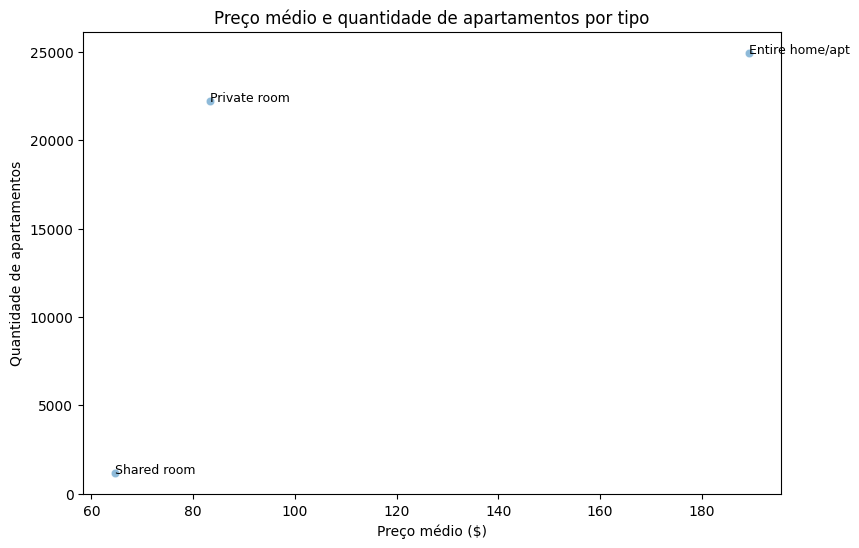

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

agrupamento_tipo = apartamentos.groupby("room_type").agg(
    quantidade=("id", "count"),
    preco_medio=("price", "mean")
).reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(data=agrupamento_tipo, x="preco_medio", y="quantidade", alpha=0.5)
for i, row in agrupamento_tipo.iterrows():
    plt.text(
        row["preco_medio"],
        row["quantidade"],
        row["room_type"],
        fontsize=9
    )

plt.title("Preço médio e quantidade de apartamentos por tipo")
plt.xlabel("Preço médio ($)")
plt.ylabel("Quantidade de apartamentos")
plt.show()

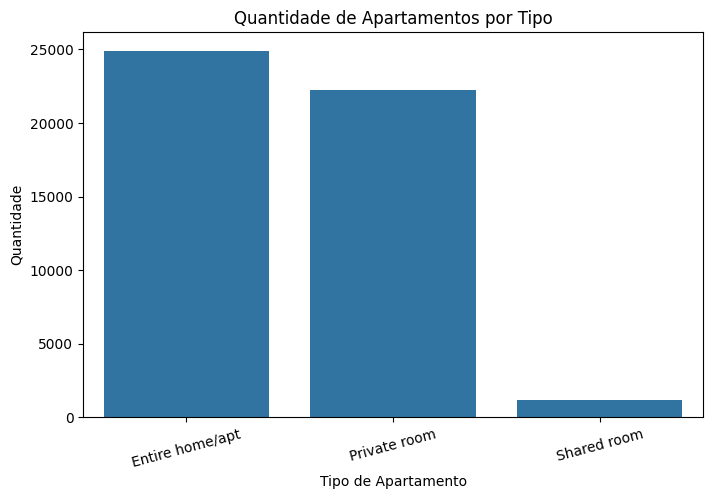

In [628]:
import seaborn as sns

tipos_apt = apartamentos["room_type"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=tipos_apt.index, y=tipos_apt.values)
plt.title("Quantidade de Apartamentos por Tipo")
plt.xlabel("Tipo de Apartamento")
plt.ylabel("Quantidade")
plt.xticks(rotation=15)
plt.show()

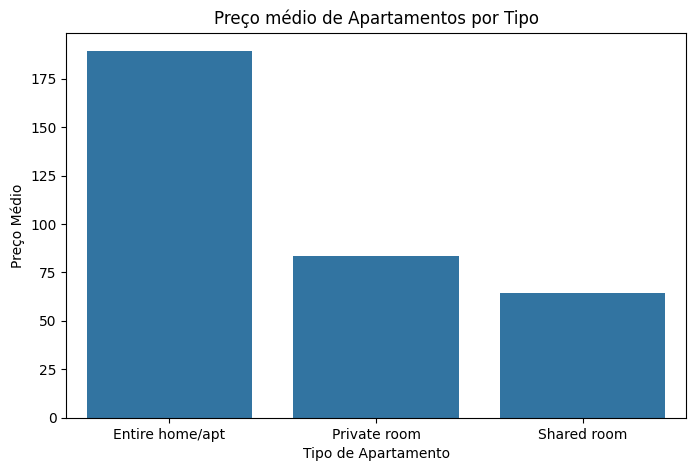

In [629]:
plt.figure(figsize=(8, 5))
sns.barplot(x=tipos_apt.index, y=apartamentos.groupby("room_type")["price"].mean())
plt.title("Preço médio de Apartamentos por Tipo")
plt.xlabel("Tipo de Apartamento")
plt.ylabel("Preço Médio")
plt.show()

### 3.4. Localização

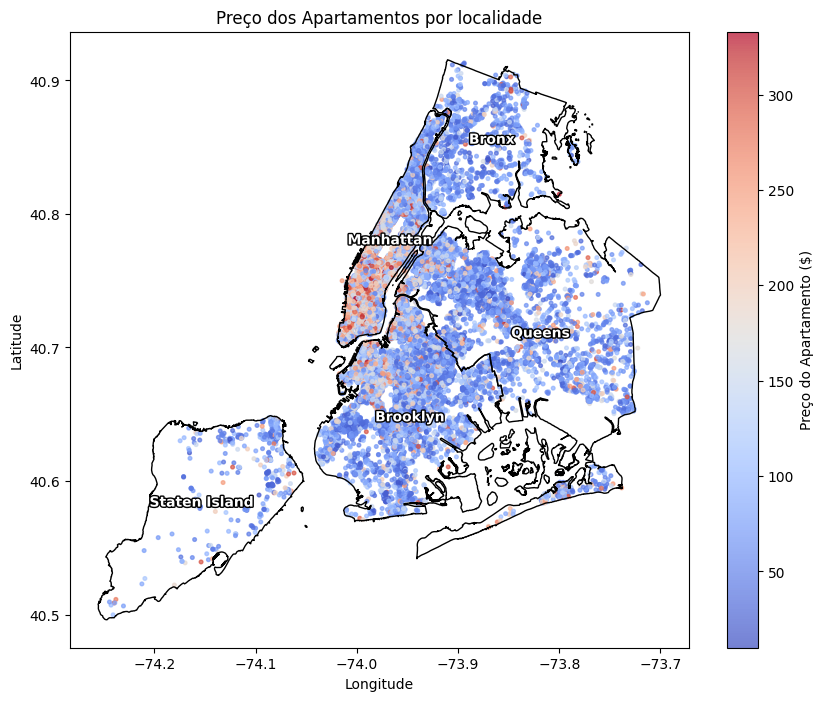

In [630]:
import geopandas as gpd
from geodatasets import get_path
import matplotlib.patheffects as pe

nyc_bairros = gpd.read_file(get_path('nybb'))
nyc_bairros = nyc_bairros.to_crs(epsg=4326) # Define o CRS para o sistema geográfico adequado (WGS 84)

apartamentos_loc = apartamentos[apartamentos['price'] < maximo].copy()
apartamentos_loc = gpd.GeoDataFrame(
    apartamentos_loc, 
    geometry=gpd.points_from_xy(apartamentos_loc.longitude, apartamentos_loc.latitude),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 8))

# Contorno dos bairros
nyc_bairros.boundary.plot(ax=ax, edgecolor="black", linewidth=1)

# Nome dos bairros
for idx, row in nyc_bairros.iterrows():
    centroid = row.geometry.centroid 
    ax.text(
        centroid.x, centroid.y, row["BoroName"],
        fontsize=10, fontweight="bold", color="white", ha="center",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

# Apartamentos
scatter = ax.scatter(
    apartamentos_loc.geometry.x, 
    apartamentos_loc.geometry.y, 
    c=apartamentos_loc['price'],
    cmap='coolwarm',
    alpha=0.7, 
    s=7
)

# Barra de cores
colorbar = plt.colorbar(scatter, ax=ax)
colorbar.set_label('Preço do Apartamento ($)')

ax.set_title('Preço dos Apartamentos por localidade')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

A partir deste gráfico é possível observar que a grande maioria dos apartamentos caros se concentra no sul da ilha de Manhattan, tendo alguns espalhados também pelos outros distritos.

#### 3.4.1. Bairro

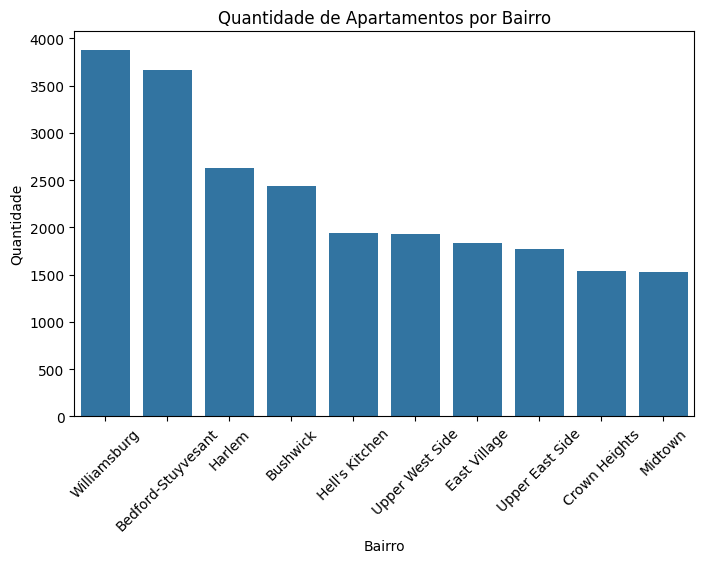

In [631]:
top_bairros_por_qtd = apartamentos["bairro"] \
    .value_counts() \
    .sort_values(ascending=False) \
    .head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_bairros_por_qtd.index, y=top_bairros_por_qtd.values)
plt.title("Quantidade de Apartamentos por Bairro")
plt.xlabel("Bairro")
plt.ylabel("Quantidade")
plt.xticks(rotation=45)
plt.show()

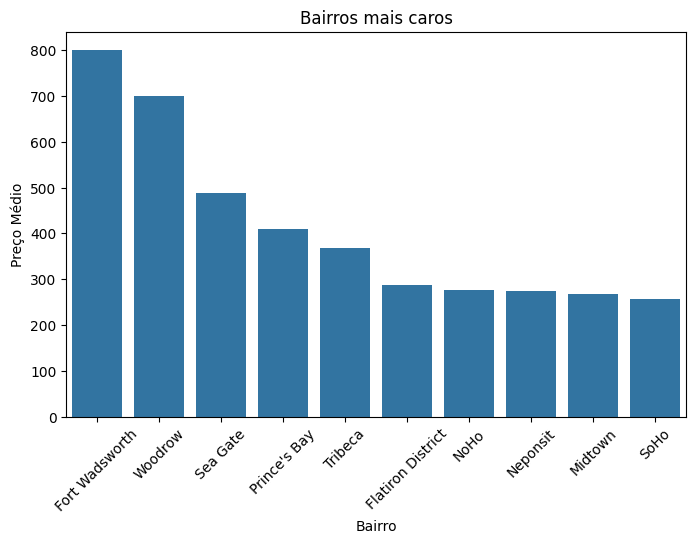

In [655]:
top_bairros_por_preco = apartamentos \
    .groupby("bairro")["price"].mean() \
    .sort_values(ascending=False) \
    .reset_index() \
    .head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x="bairro", y="price", data=top_bairros_por_preco)
plt.title("Bairros mais caros")
plt.xlabel("Bairro")
plt.ylabel("Preço Médio")
plt.xticks(rotation=45)
plt.show()

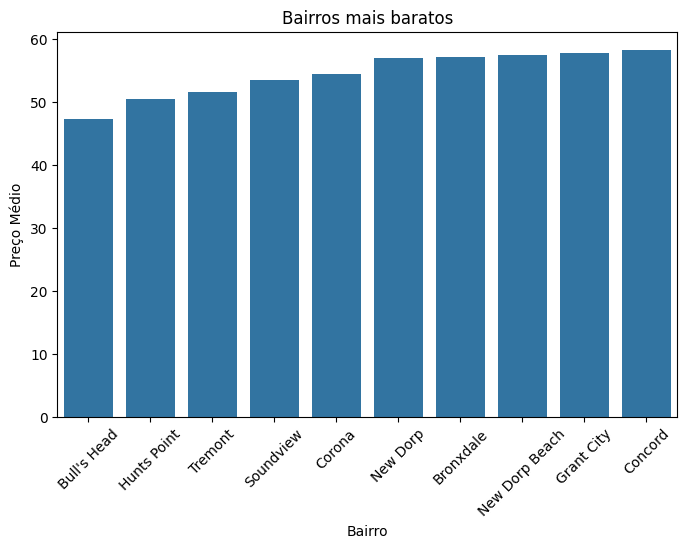

In [654]:
bairros_mais_baratos = apartamentos \
    .groupby("bairro")["price"].mean() \
    .sort_values(ascending=True) \
    .reset_index() \
    .head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x="bairro", y="price", data=bairros_mais_baratos)
plt.title("Bairros mais baratos")
plt.xlabel("Bairro")
plt.ylabel("Preço Médio")
plt.xticks(rotation=45)
plt.show()

#### 3.4.2. Distrito

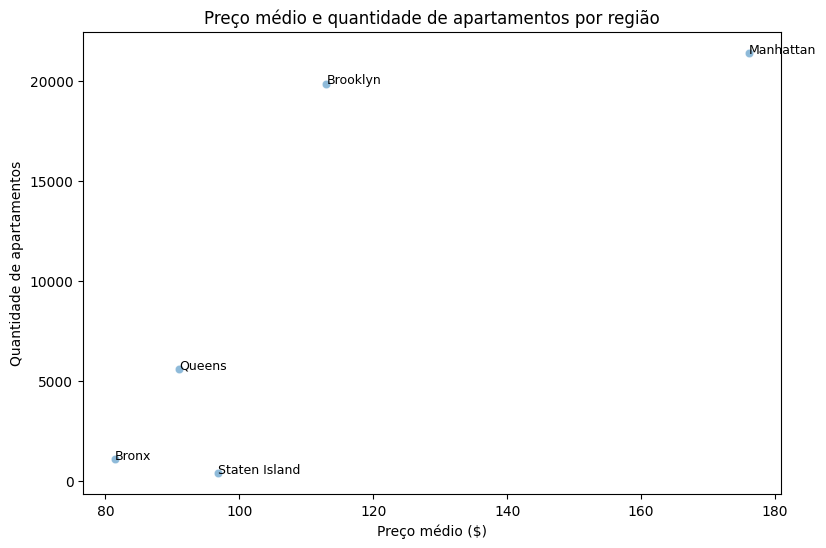

In [633]:
agrupamento_distrito = apartamentos.groupby("bairro_group").agg(
    quantidade=("id", "count"),
    preco_medio=("price", "mean")
).reset_index()

plt.figure(figsize=(9, 6))
sns.scatterplot(data=agrupamento_distrito, x="preco_medio", y="quantidade", alpha=0.5)
for i, row in agrupamento_distrito.iterrows():
    plt.text(
        row["preco_medio"],
        row["quantidade"],
        row["bairro_group"],
        fontsize=9
    )

plt.title("Preço médio e quantidade de apartamentos por região")
plt.xlabel("Preço médio ($)")
plt.ylabel("Quantidade de apartamentos")
plt.show()

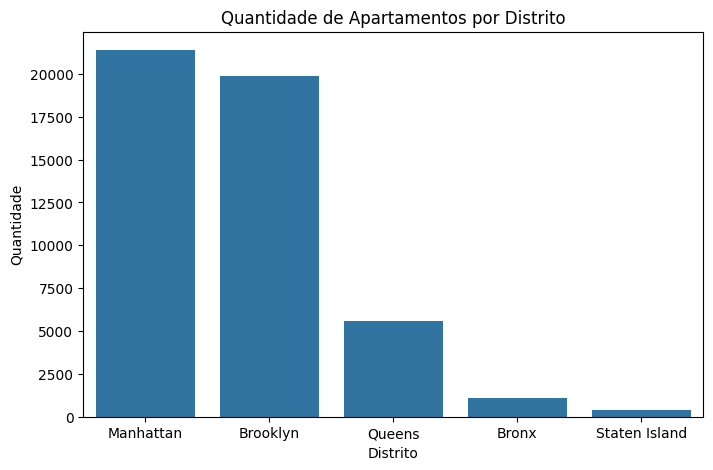

In [634]:
import matplotlib.pyplot as plt
import seaborn as sns

regioes = apartamentos["bairro_group"].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=regioes.index, y=regioes.values)
plt.title("Quantidade de Apartamentos por Distrito")
plt.xlabel("Distrito")
plt.ylabel("Quantidade")
plt.show()

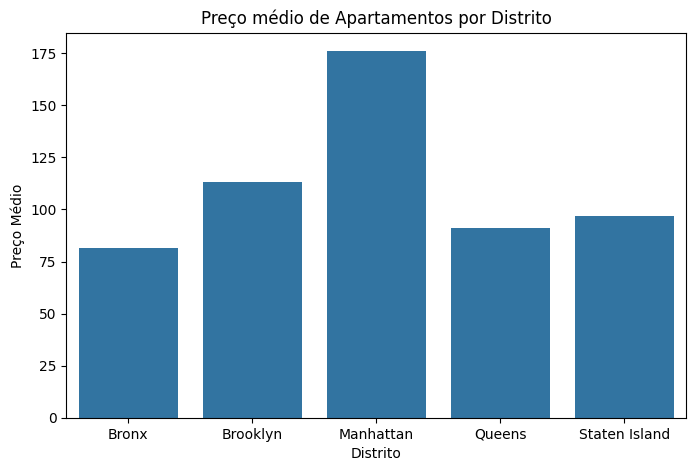

In [653]:
data = apartamentos.groupby("bairro_group")["price"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="bairro_group", y="price", data=data)
plt.title("Preço médio de Apartamentos por Distrito")
plt.xlabel("Distrito")
plt.ylabel("Preço Médio")
plt.show()

#### 3.4.3. Restaurantes próximos

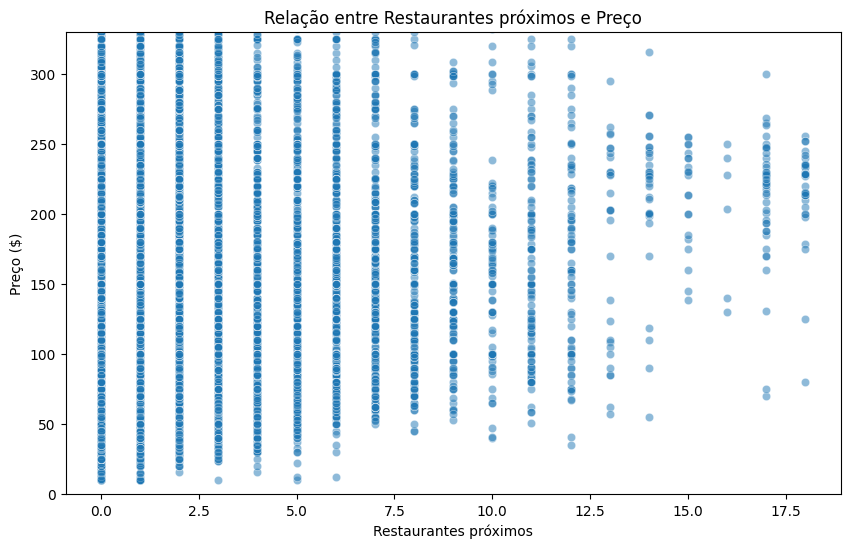

In [636]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=apartamentos, x="num_restaurantes_proximos", y="price", alpha=0.5)

plt.title("Relação entre Restaurantes próximos e Preço")
plt.xlabel("Restaurantes próximos")
plt.ylabel("Preço ($)")
plt.ylim(0, apartamentos["price"].quantile(0.95))
plt.show()

Apesar de o número de restaurante próximos não influenciar tanto no preço em geral, é possível observar que conforme o número de restaurantes aumenta, o número de apartamentos baratos diminui.

## 4. Respondendo as perguntas

### 4.1. Onde seria mais indicada a compra?

Caso a pessoa deseje ficar em lugares luxuosos, próximos de vários restaurantes, o mais recomendado é alugar um apartamento em Manhattan.

Caso esteja com um orçamento menor, o distrito com a menor média de preço é o Bronx. Os bairros mais baratos são Bull's Head, Hunts Point e Tremont.

### 4.2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Como podemos observar no tópico 3.2, a correlação do preço com o número mínimo de noites ou a disponibilidade ao longo do ano é baixa.

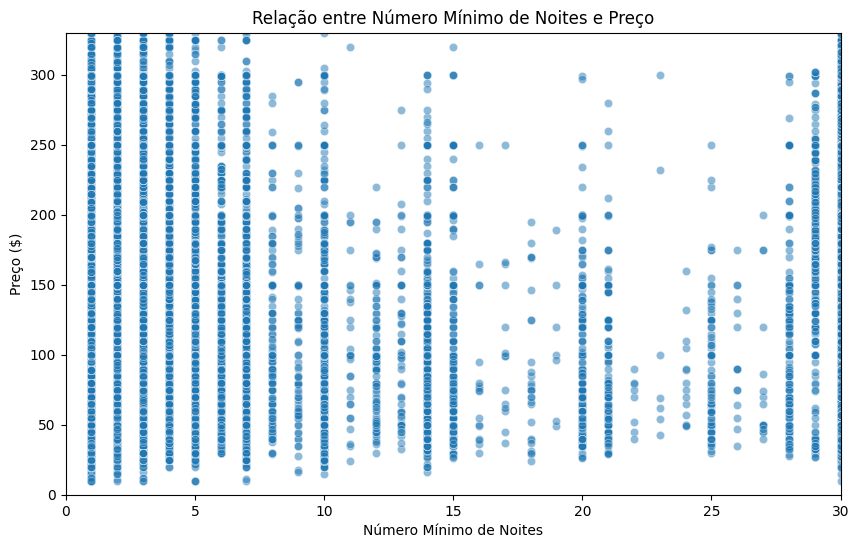

In [637]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=apartamentos, x="minimo_noites", y="price", alpha=0.5)

plt.title("Relação entre Número Mínimo de Noites e Preço")
plt.xlabel("Número Mínimo de Noites")
plt.ylabel("Preço ($)")
plt.ylim(0, apartamentos["price"].quantile(0.95))
plt.xlim(0, apartamentos["minimo_noites"].quantile(0.95))
plt.show()

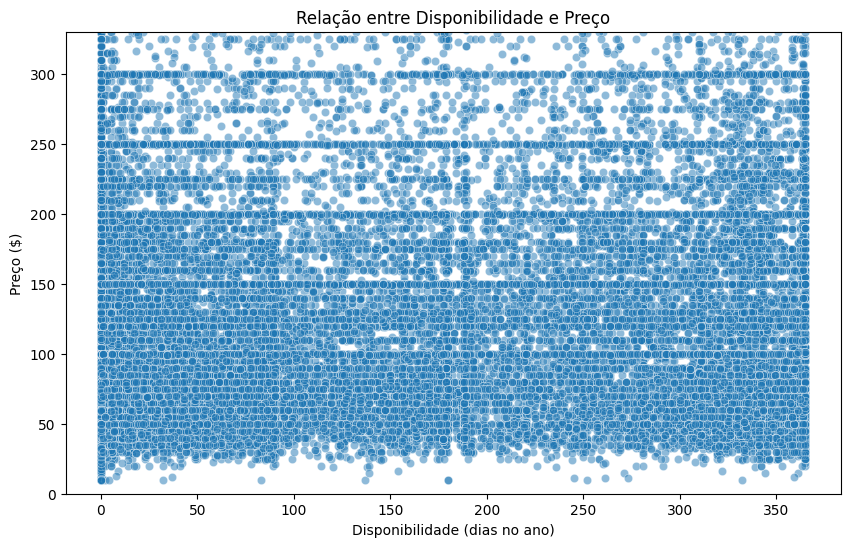

In [638]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=apartamentos, x="disponibilidade_365", y="price", alpha=0.5)

plt.title("Relação entre Disponibilidade e Preço")
plt.xlabel("Disponibilidade (dias no ano)")
plt.ylabel("Preço ($)")
plt.ylim(0, apartamentos["price"].quantile(0.95))
plt.show()

Conclusão: tanto pelos números quanto pelo gráfico, é possível identificar que esses fatores influenciam muito pouco o preço.

### 4.3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Para analisar esta relação, serão selecionados os apartamentos cujo preço é ao menos duas vezes maior que a média do bairro, incluindo os outliers ignorados nas análises anteriores.

A partir disso, é possível analisar quais são as palavras ou conjuntos de palavras mais relacionados às diferenças de preço:

In [639]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

apartamentos_caros = outliers_bairro[outliers_bairro['proporcao'] > 2]
vectorizer = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1,3))
modelo = LinearRegression()

x = vectorizer.fit_transform(apartamentos_caros["nome"])
y = apartamentos_caros["price"]
modelo.fit(x, y)

peso_ngramas = pd.DataFrame({
    'palavra': vectorizer.get_feature_names_out(),
    'peso': modelo.coef_,
    'recorrencia': x.toarray().sum(axis=0)
})

peso_ngramas.sort_values(by='peso', ascending=False).head(10)

,palavra,peso,recorrencia
614,city apartment,13180.588790,3
1281,manhattan views,11843.203047,3
701,doorman gym,11222.354045,13
852,film location,10895.963527,2
1878,time sqr,9779.479528,2
877,free wifi,9768.490910,3
1140,lit,9633.757970,2
1539,private deck,9140.903652,4
1981,village 2br,9108.790547,3
81,2br heart,8961.151152,2


Analisando cada conjunto de palavras:
- <b>"city apartment"</b>: buscando manualmente no dataset, é possível perceber que esta sequência normalmente está contida quase sempre na frase "New York City Apartment", tendo variações como "Long Island City Apartment", "Carnegie City Apartment", etc.
- <b>"manhattan views"</b>: se refere a imóveis que tem vista para ilha de Manhattan, indicando que este é um grande diferencial na cidade
- <b>"doorman gym"</b>: indica que o imóvel possui porteiro e academia disponível
- <b>"film location"</b>: o local pode ser utilizado para filmagens
- <b>"time sqr"</b>: o local fica próximo à famosa Times Square
- <b>"free wifi"</b>: o local tem rede de WiFi gratuita
- <b>"lit"</b>: local iluminado
- <b>"private deck"</b>: inclui um terraço ou área externa exclusivo para o morador/locatário
- <b>"village 2br"</b>:
    - <b>"village"</b>: pode ser um imóvel no estilo "vila", ou um imóvel localizado em bairros como "East Village", "West Village", etc.
    - <b>"2br"</b>: "br" neste caso é abreviação para "bedroom", ou seja, é um imóvel com dois dormitórios
- <b>"2br heart"</b>: também com dois dormitórios; heart nesse caso geralmente está inserido em frases como "In the heart of Manhattan (No coração de Manhattan)", ou seja, são imóveis localizados no centro de seus bairros

## 5. Modelo preditivo

Aqui será desenvolvido um modelo capaz de atribuir um preço à apartamentos com base nas suas características.

Estamos lidando com um problema de regressão, pois o objetivo é prever um valor numérico, e não classificar os apartamentos em categorias como "barato" ou "caro", o que caracterizaria um problema de classificação.

Alguns passos já foram adiantados para a criação do modelo preditivo, como:
- Descoberta das variáveis mais influentes
- Tratamento de outliers
- Conversão de variáveis categóricas
- Identificação de termos no nome do apartamento que afetam o preço

Entretanto, a forma como os bairros, os distritos e os tipos de apartamento foram convertidos no cálculo da correlação não é a ideal para ser usada no modelo, pois este pode interpretar, por exemplo, que o bairro 4 é duas vezes melhor que o bairro 2, sendo que são variáveis qualitativas nominais, não ordinais. Também é necessário normalizar variáveis numéricas que têm escalas muito diferentes:

In [640]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def preparar_dataset(apartamentos_df):
    df = pd.get_dummies(
        apartamentos_df,
        columns=["bairro", "bairro_group", "room_type"],
        drop_first=True
    ).select_dtypes(include=['int64', 'float64', 'bool']).drop(columns=['id', 'host_id'])
    df['days_since_last_review'] = (pd.Timestamp.now() - apartamentos['ultima_review']).dt.days

    scaler = StandardScaler()
    df[["minimo_noites", "numero_de_reviews", "reviews_por_mes", "disponibilidade_365"]] = scaler.fit_transform(
        df[["minimo_noites", "numero_de_reviews", "reviews_por_mes", "disponibilidade_365"]]
    )
    df["nome"] = apartamentos_df["nome"]

    return df

df = preparar_dataset(apartamentos)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48298 entries, 0 to 48893
Columns: 237 entries, latitude to nome
dtypes: bool(226), float64(7), int64(3), object(1)
memory usage: 14.8+ MB


### 5.1. Escolha do modelo

Temos algumas opções de modelos para serem utilizados:

#### Regressão Linear

O modelo mais básico, onde o preço é modelado como uma combinação linear das variáveis.

Prós: 
   - Rápido e eficiente para conjuntos de dados menores.  
   - Fácil de interpretar (cada coeficiente mostra o impacto de uma variável no preço).  
   - Boa base para análise inicial.

Contras:
   - Assume uma relação linear entre variáveis, o que raramente acontece no mundo real.  
   - Sensível a outliers, pois os valores extremos distorcem a reta de regressão.  
   - Não consegue capturar interações entre variáveis (exemplo: o impacto do bairro pode depender do tipo de acomodação).


#### Regressão Regularizada

Variante da Regressão Linear que adiciona uma penalização (L1 no Lasso e L2 no Ridge) para evitar overfitting.

Prós: 
   - Melhor que a regressão linear pura, pois reduz overfitting.  
   - Lasso pode zerar variáveis irrelevantes, ajudando na seleção de features.  
   - Mais estável com muitas variáveis.

Contras:
   - Ainda assume relações lineares.  
   - Não captura interações entre variáveis automaticamente.

#### Random Forest Regressor

Modelo baseado em múltiplas árvores de decisão, combinando previsões de várias árvores para reduzir overfitting.

Prós:
   - Captura relações não lineares automaticamente.  
   - Robusto contra outliers e dados faltantes.  
   - Ajusta melhor as interações entre variáveis.

Contras:
   - Pode ser lento e consumir muita memória, especialmente com muitos dados.  
   - Menos interpretável que a regressão linear.

#### XGBoost / LightGBM

Modelos avançados baseados em árvores de decisão que treinam iterativamente, dando mais peso aos erros anteriores.

Prós:
   - Melhor precisão entre os modelos testados.  
   - Captura relações complexas e interações entre variáveis.  
   - Treina mais rápido que Random Forest em datasets grandes.

Contras: 
   - Mais difícil de ajustar (exige otimização de hiperparâmetros).  
   - Pode superajustar se não for bem regulado.

### 5.2. Executando o modelo escolhido

O modelo XGBoost foi o escolhido por ter melhor precisão entre os modelos testados.

In [641]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
import numpy as np

def get_xy(df):
    y = np.log1p(df["price"])
    X_text = vectorizer.transform(df["nome"]) # Processar o texto com n-gramas
    X_numeric = df.drop(columns=["nome", "price"])
    X_numeric = np.array(X_numeric, dtype=np.float64)
    assert X_numeric.shape[0] == X_text.shape[0]
    X = hstack([X_numeric, X_text])
    return X, y

X, y = get_xy(df)
# Separar dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo XGBoost
modelo = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
modelo.fit(X_train, y_train)

# Avaliação do modelo
y_pred = modelo.predict(X_test)

In [642]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Converter previsão de log(price) para preço normal
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
preco_medio = np.expm1(y_test).mean()
erro_percentual = (mae / preco_medio) * 100

print(f"MAE: {mae:.2f} (erro médio absoluto)")
print(f"RMSE: {rmse:.2f} (raiz do erro quadrático médio)")
print(f"Erro Médio Absoluto (MAE) como % do preço médio: {erro_percentual:.2f}%")


MAE: 38.50 (erro médio absoluto)
RMSE: 70.68 (raiz do erro quadrático médio)
Erro Médio Absoluto (MAE) como % do preço médio: 28.06%


Salvando o modelo em .pkl

In [643]:
import joblib

joblib.dump(modelo, 'modelos/modelo_precificacao.pkl')

['modelos/modelo_precificacao.pkl']

### 5.3. Atribuindo preço a novo apartamento

In [644]:
novos_apartamentos = pd.DataFrame([{
    "id": 1,
    "host_id": 1,
    "bairro_group": "Manhattan",
    "bairro": "Midtown",
    "latitude": 40.75362,
    "longitude": -73.98377,
    "room_type": "Entire home/apt",
    "minimo_noites": 1,
    "numero_de_reviews": 45,
    "reviews_por_mes": 0.38,
    "calculado_host_listings_count": 2,
    "disponibilidade_365": 355,
    "nome": "Skylit Midtown Castle"
}])
novos_apartamentos["num_restaurantes_proximos"] = contagem_restaurantes(novos_apartamentos)
novos_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1 non-null      int64  
 1   host_id                        1 non-null      int64  
 2   bairro_group                   1 non-null      object 
 3   bairro                         1 non-null      object 
 4   latitude                       1 non-null      float64
 5   longitude                      1 non-null      float64
 6   room_type                      1 non-null      object 
 7   minimo_noites                  1 non-null      int64  
 8   numero_de_reviews              1 non-null      int64  
 9   reviews_por_mes                1 non-null      float64
 10  calculado_host_listings_count  1 non-null      int64  
 11  disponibilidade_365            1 non-null      int64  
 12  nome                           1 non-null      object 

Preparando o dataset para a nova análise:

In [ ]:
df_novo = preparar_dataset(novos_apartamentos)
colunas_faltantes = set(df.columns) - set(df_novo.columns)
colunas_sobrando = set(df_novo.columns) - set(df.columns)

df_novo.drop(columns=colunas_sobrando, inplace=True)
for coluna in colunas_faltantes:
    df_novo[coluna] = False

Executando novamente o modelo a partir do arquivo salvo:

In [ ]:
modelo = joblib.load('modelos/modelo_precificacao.pkl')
X, y = get_xy(df_novo)

y_pred_novo = modelo.predict(X)
y_pred_novo_real = np.expm1(y_pred_novo)
df_novo["preco_previsto"] = y_pred_novo_real

In [647]:
df_novo[['nome', 'preco_previsto']]

,nome,preco_previsto
0,Skylit Midtown Castle,204.191193


O preço previsto para este apartamento é de $204.19